# Test and experiments using Hidden Markov Models for Part-of-speech Tagging.
_Antonio Crespí Tobeña_



This notebook is a complement of the code provided in the repository https://github.com/Tonicrespit/hmm_pos_tagger. 

Here, we present a few examples to explain how the code works and how to perform your own tests. 

As the experiments are performed on texts with millions of words, you can find that some examples take some time to run. Before each section you can find an estimate of how long it takes to execute each chunk of code. Keep in mind that these times are just a guidance and it may change depending on the power or workload of your machine.

First of all, we need the following libraries:

In [1]:
# Core of the Hidden Markov Model
from HMM.Markovify import *
from HMM.Utils.CrossValidation import cross_validation_score

# Corpus to test the model
from nltk.corpus import brown

# Utilities to store, manipulate and display data
import pandas as pd
import numpy as np
import random
from math import ceil
import importlib
import json

# Progress bar to get feedback from the loops
from HMM.Utils.ProgressBar import log_progress

# Accuracy for news text.
_Time to run: between 2 and 4 minutes each of the last two chunks_

This a simple introduction example to check how the cross validation works. First, we need a tagged corpus to train the model:

In [2]:
corpus = brown.tagged_sents(categories='news', tagset='universal')

Once we have the training text, we can create the model. At the moment, the only parameter of the model is the smoothing technique used to deal with unknown words. Two are available:

- 'max' to use the most probable Part-Of-Speech (POS) tag.
- 'laplace' to use LaPlace smoothing.

In this example we use the most probable POS-tag.

In [3]:
model = Markovify(smoothing='max')

With a model specified, we can call the function `cross_validate_score` to do the training. As it may take a few minutes, you can change the parameter `verbose` to `true` to get updates on how the training is going.

You can also increase or decrease `n_jobs` to change the number of processor cores assigned to the task.

In [4]:
brown_news_score = cross_validation_score(model, sentences=corpus, cv=5, verbose=False, n_jobs=8)

print(json.dumps(brown_news_score, indent=1))

[
 {
  "accuracy": 0.936846221527031,
  "precision": 0.9393671341878456,
  "recall": 0.936846221527031
 },
 {
  "accuracy": 0.9336578797451965,
  "precision": 0.9356507148146999,
  "recall": 0.9336578797451965
 },
 {
  "accuracy": 0.9444305631902453,
  "precision": 0.9466912063700618,
  "recall": 0.9444305631902453
 },
 {
  "accuracy": 0.928161063096368,
  "precision": 0.9320455034786703,
  "recall": 0.928161063096368
 },
 {
  "accuracy": 0.9191194180837228,
  "precision": 0.9261004846198038,
  "recall": 0.9191194180837228
 }
]


The same process can be repeated with different number of folds to see if there is a relation between the number of folds and the accuracy of the model.

Note that we run the test with only a 20% of the original _corpus_. The only reason behind this is to reduce the execution time. If you want to run the experiment on the full _corpus_ replace `sample_corpus` with `corpus` in the `sentences=sample_corpus` parameter of  the cross-validation. 

In [5]:
sample_idx = random.sample(range(0, len(corpus)), ceil(len(corpus) * 0.2))
sample_corpus = list(corpus[i] for i in sample_idx)

nfolds = [3, 5, 10]
scores = []
for n in log_progress(nfolds):
    model = Markovify(smoothing='max')
    model_scores = cross_validation_score(model, sentences=sample_corpus, cv=n, verbose=False)
    scores.append(np.max([model['accuracy'] for model in model_scores]))
    
print(scores)

[0.888663967611336, 0.8947626040137053, 0.9066187788609543]


# Comparison of different smoothing techniques.
_Time to run: between 5 and 8 minutes_

In this experiment we are going to compare the two approaches to dealing with unknown words. First, we are going to train a model using cross-validation for the LaPlace (or additive) smoothing and then for the most probable POS-tag.

In [6]:
corpus = brown.tagged_sents(categories='news', tagset='universal')

model_laplace = Markovify(smoothing='laplace', alpha=1)
brown_news_accuracy_laplace = cross_validation_score(model_laplace, sentences=corpus, verbose=False)
print('Best accuracy for Laplace smoothing: {}.'.format(np.max([model['accuracy'] for model in brown_news_accuracy_laplace])))

model_max = Markovify(smoothing='max')
brown_news_accuracy_max = cross_validation_score(model_max, sentences=corpus, verbose=False)
print('Best accuracy for most probable POS-tag: {}.'.format(np.max([model['accuracy'] for model in brown_news_accuracy_max])))

Best accuracy for Laplace smoothing: 0.9161208329259947.
Best accuracy for most probable POS-tag: 0.9444305631902453.


# POS-tag distribution.
_Time to run: between 2 and 4 minutes_

Due to the nature of the POS-tags, it is obvious that not every POS-tag will appear the same amount of times in a text. But how skewed is their distribution?

To find out, we just have to train a model using cross-validation and get its tag count:

In [7]:
corpus = brown.tagged_sents(categories='adventure', tagset='universal')

m = Markovify(smoothing='max')
acc, m = cross_validation_score(m, sentences=corpus, return_model=True)

Text(0.5,0,'Recuento del tag')

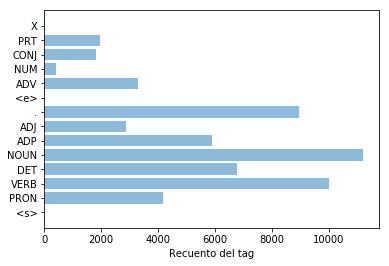

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

tags = m.hmm.q
pos = np.arange(len(tags))
counts = m.hmm.tag_count

plt.barh(pos, counts, align='center', alpha=0.5)
plt.yticks(pos, tags)
plt.xlabel('Recuento del tag')

In [9]:
counts

array([    0.,  4160., 10024.,  6776., 11216.,  5910.,  2882.,  8964.,
           0.,  3289.,   394.,  1805.,  1950.,    34.])

As expected, the support of the tags varies greatly. This is one of the main reasons why the most probable POS-tag approach to dealing with unknown words is so effective.

# Training a model with an adventures _corpus_ to tag a news text.
_Time to run: between 1 and 2 minutes_

This is a simple experiment to train a model without using cross-validation. It can be useful if you need to get faster results or you want to test a model using a different _corpus_.

In [10]:
corpus_advs = brown.tagged_sents(categories='adventure', tagset='universal')
corpus_news = brown.tagged_sents(categories='news', tagset='universal')

# Build the model using news
model = Markovify(smoothing='max')
model = model.fit(corpus_news)

# Get predicions on adventures
tagged = model.predict(corpus_advs)

One way to display the results is using a table were each word comes with its real tag and the predicted tag. It is useful if you want to specifically check a word or the text to predict is small.

If you want to see more than the first 10 rows, change the parameter of `results.head(10)` to the desired number.

In [11]:
advs_records = [item for sublist in corpus_advs for item in sublist]
predicted_tags = [item for sublist in tagged for item in sublist]

results = pd.DataFrame.from_records(advs_records)
results.columns = ["Word", "Tag"]
results['Predicted'] = predicted_tags
results.head(10)

,Word,Tag,Predicted
0,Dan,NOUN,NOUN
1,Morgan,NOUN,NOUN
2,told,VERB,VERB
3,himself,PRON,PRON
4,he,PRON,PRON
5,would,VERB,VERB
6,forget,VERB,VERB
7,Ann,NOUN,NOUN
8,Turner,NOUN,NOUN
9,.,.,.


If you make predictions about hundreds, thousands, or even millions of words, checking the results as a table will be impossible. 

You can instead plot a normalized confusion matrix where you will see each POS-tag with its accuracy, type-I error and type-II error.

Note that the confusion matrix is normalized by default. If you want to see the matrix without normalization specify `normalize=False` to the `confusion_matrix` function.

In [12]:
from HMM.Utils.Scoring import *

cm = confusion_matrix(corpus_advs, tagged)

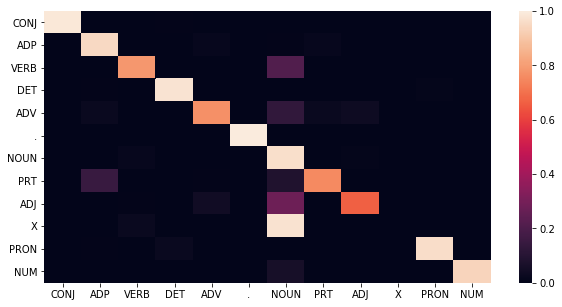

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.rcParams['figure.figsize'] = [10, 5]

sn.heatmap(cm)

As we can see in the confusion matrix, the vast majority of errors are associated with the NOUN POS-tag, which is the most frequent -as we have seen in the last experiment-. 

The cause of this distribution of errors is the approach to dealing with unknown words. As we assign NOUN -the most probable tag- to each unknown word, this tag is going to have a lot more errors than the others.

# Accuracy of the model based on the size of the training corpus and POS-tag distribution.
_Time to run: between 4 and 7 minutes_

Most --if not all-- statistical models need a minimum of training samples to adjust their parameters in order to make accurate predictions. This is no different for the Hidden Markov Models. This experiment is designed to find how long a training _corpus_ has to be to provide acceptable results.

In order to achieve this goal, we are going to use cross-validation on seven corpus:
- 1% of the adventure texts.
- 5% of the adventure texts.
- 10% of the adventure texts.
- 25% of the adventure texts.
- 50% of the adventure texts.
- 80% of the adventure texts.
- 100% of the adventure texts.

In [14]:
corpus = brown.tagged_sents(categories='adventure', tagset='universal')

corpus_len = len(corpus)
train_size = [  1 * corpus_len / 100, 
                5 * corpus_len / 100, 
               10 * corpus_len / 100, 
               25 * corpus_len / 100, 
               50 * corpus_len / 100, 
               80 * corpus_len / 100, 
              100 * corpus_len / 100]

accuracy = []
for length in log_progress(train_size):
    partial_corpus = list(corpus[i] for i in range(0, ceil(length)))

    m = Markovify(smoothing='max')
    fold_scores = cross_validation_score(m, sentences=partial_corpus)
    accuracy.append(np.max([fold['accuracy'] for fold in fold_scores]))

Once are the models are trained, we can plot their accuracies:

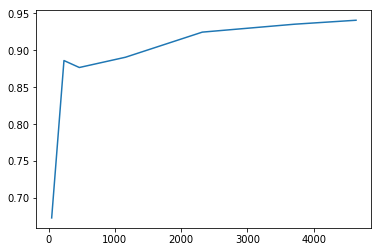

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(train_size, accuracy)

As expected, the bigger the training _corpus_ the better the model. However, a _corpus_ with ~2500 sentences already provides an accuracy of more than 90%.